In [33]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import drone_env
from drone_env import running_average, plot_rewards
from tqdm import tqdm, trange
from IPython import display
from SAC_agents import RandomAgent, CriticNN
from collections import namedtuple, deque
from SAC_agents import SACAgents, ExperienceBuffers, TrainedAgent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Checking the environment

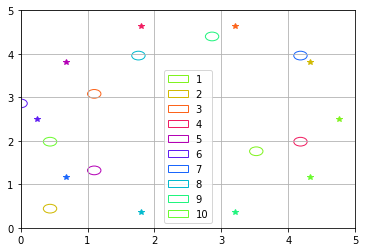

In [2]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)
# print(env)
env.show()

## Simple gradient control. $ u_i = -\nabla _x c_i $

$$ c_i = q|| x_i-x_B ||^2 +  b \sum_{j \in N_i} \log (\frac{\hat{d}_i}{|| x_i-x_j || - r_i -r_j})$$

$$ \nabla _x c_i = 2q (x_i-x_B) - b \sum_{j \in N_i} \frac{1}{|| x_i-x_j || -r_i -r_j} \cdot \frac{x_i-x_j}{|| x_i -x_j ||} $$


100%|██████████| 500/500 [00:02<00:00, 189.80it/s]


Total collisions = 0


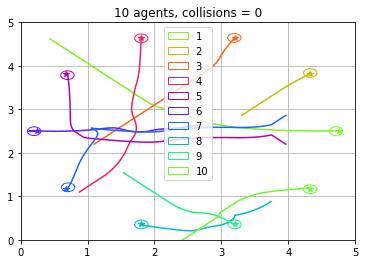

In [3]:
env = drone_env.drones(n_agents = 10, n_obstacles = 0, grid = [5,5], end_formation="O", simplify_zstate = True)


T = 5
times = np.arange(0,T,step=drone_env.dt) + drone_env.dt

total_collisions = 0
reward_history = np.zeros([len(times), env.n_agents])

trajectory = [env.state.copy()]

for iter,t in enumerate(tqdm(times)):
## Simple gradient controller u_i = -grad_i, assuming Nj = V
    state = env.state
    
    # calculate actions based on current state
    actions = drone_env.gradient_control(state,env)

    # Update environment one time step with the actions
    new_state, new_z, rewards, n_collisions, finished = env.step(actions)

    total_collisions += n_collisions
    reward_history[iter,:] = np.mean(rewards)
    trajectory.append(new_state.copy())

# print(env.trajectory[-1])
print(f"Total collisions = {total_collisions}")
env.plot(trajectory)

In [57]:
# env.animate(frame_time = 0.05, frames = 30)


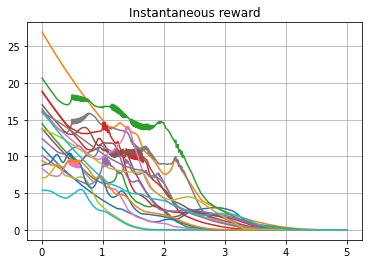

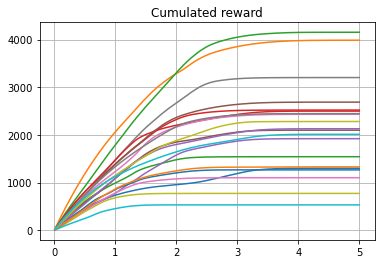

In [58]:
plt.plot(times,-reward_history);
plt.grid(True);
plt.title("Instantaneous reward")
plt.show()

cumulated_reward = np.cumsum(reward_history,0)

plt.plot(times,-cumulated_reward);
plt.grid(True);
plt.title("Cumulated reward")  
plt.show()

### Checking z state 

In [116]:

### Set up parameters ###
n_agents = 3
deltas = np.ones(n_agents)*2
env = drone_env.drones(n_agents=n_agents, n_obstacles=0, grid=[5, 5], end_formation="O", deltas=deltas ,simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 1

T = 5 # Simulate for T seconds (default dt = drone_env.dt = 0.01s) t_iter t=500

### 

# Initialize variables
total_collisions_list = deque()
total_reward_list = deque()
mean_critic_error = np.zeros([env.n_agents, N_Episodes])
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

times = np.arange(0, T, step=drone_env.dt) + drone_env.dt
EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)


agents = TrainedAgent(file_name="Q_test_1000eps-critics.pth", n_agents=env.n_agents)
print("### Running Trained agent (no learning)")
print(f"Episodes = {N_Episodes}, Time iterations = {len(times)} (T = {T}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}")

for episode in EPISODES:

    # reward_history = np.zeros([len(times), env.n_agents])
    trajectory = [env.state.copy()]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)
    # SIMULATION OVER T
    for t_iter, time in enumerate(times):
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states

        # calculate actions based on current state
        actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        # reward_history[t_iter,:] = reward
        trajectory.append(new_state.copy())

    # END OF EPISODE
    # Append episode reward
    total_reward_list.append(total_episode_reward)
    total_collisions_list.append(total_episode_collisions)

    # Test Critic values
    Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    critic_error = [np.mean(np.power(Q_simulated[i]-Q_approx[i],2)) for i in range(env.n_agents)]

    mean_critic_error[:,episode] = np.array([critic_error])

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_list, 50)[-1]
    average_collisions = running_average(total_collisions_list, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter+1} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter+1}")

    # Plot current trajectory

    if episode >= N_Episodes-0:
        env.plot(trajectory)

        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_simulated[i], label=f"i={i}, simulated Q", color = agent_color)
            plt.plot(times,Q_approx[i],"--" , label=f"i={i}, approx Q", color = tuple(0.9*x for x in agent_color))
        plt.legend()
        plt.show()


Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[4.4  4.18 0.   0.   0.1 ]
 [0.44 2.2  0.   0.   0.1 ]
 [0.66 1.54 0.   0.   0.1 ]]
safety distance for each agent:
 [3.69 3.69 3.69]
Deltas disk radius for each agent: 
 [2. 2. 2.]
Obstacles [x, y, r]:
 []



Episode:   0%|          | 0/1 [00:00<?, ?it/s]

Loaded Critic, n_agents = 10, discount = 0.99. Network model[0]: CriticNN(
  (input_layer): Linear(in_features=8, out_features=400, bias=True)
  (input_layer_activation): ReLU()
  (hidden_layer1): Linear(in_features=400, out_features=200, bias=True)
  (hidden_layer1_activation): ReLU()
  (output_layer): Linear(in_features=200, out_features=1, bias=True)
)
### Running Trained agent (no learning)
Episodes = 1, Time iterations = 500 (T = 5s, dt = 0.01s)
N of agents = 3


Episode 0 - Reward/Collisions/Steps: -265.6/0/500 - Average: 0.0/0.00/500: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


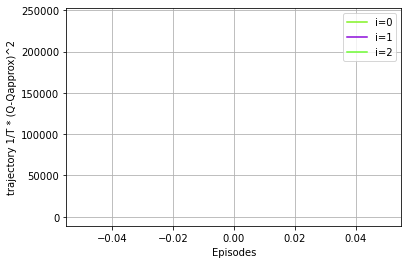

In [117]:
# plot_rewards(total_reward_list,total_collisions_list, n_ep_running_average=5)

plt.figure()
for i in range(env.n_agents):
        agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
        plt.plot(range(N_Episodes),mean_critic_error[i,:], label=f"i={i}", color = agent_color)
plt.xlabel("Episodes")
plt.ylabel("trajectory 1/T * (Q-Qapprox)^2")
plt.legend()
plt.grid()
plt.show()

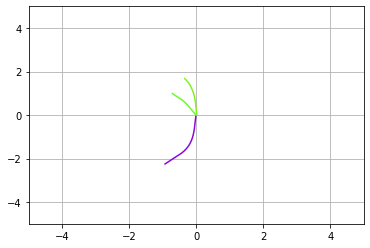

In [118]:

plt.figure()
plt.grid()
plt.xlim(-5,5)
plt.ylim(-5,5)

for i in range (env.n_agents):
    z_states_agent = [exp.z_state for exp in buffers.buffers[i]]

    zi = np.zeros([len(z_states_agent), 2])
    zj1 = np.zeros([len(z_states_agent), 2])
    zj2 = np.zeros([len(z_states_agent), 2])

    for t, z_sate in enumerate(z_states_agent):
        zi[t,:]  = z_sate[0:2]
        zj1[t,:] = z_sate[2:4]
        zj2[t,:] = z_sate[4:6]

    agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
    plt.plot(zi[:,0],zi[:,1], color = agent_color)

plt.show()

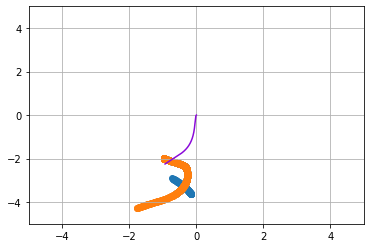

In [123]:
plt.figure()
plt.grid()
plt.xlim(-5,5)
plt.ylim(-5,5)

i = 1
z_states_agent = [exp.z_state for exp in buffers.buffers[i]]

zi = np.zeros([len(z_states_agent), 2])
zj1 = np.zeros([len(z_states_agent), 2])
zj2 = np.zeros([len(z_states_agent), 2])

for t, z_sate in enumerate(z_states_agent):
    zi[t,:]  = z_sate[0:2]
    zj1[t,:] = z_sate[2:4] + zi[t,:]
    zj2[t,:] = z_sate[4:6] + zi[t,:]

agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
plt.plot(zi[:,0],zi[:,1], color = agent_color)
plt.scatter(zj1[:,0],zj1[:,1])
plt.scatter(zj2[:,0],zj2[:,1])

plt.show()

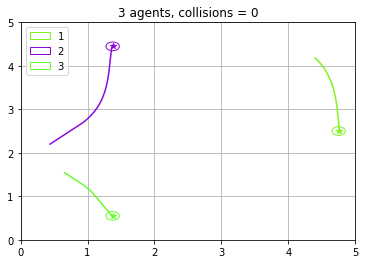

In [119]:
env.plot(trajectory)

In [ ]:
env.animate(trajectory)

### Tests

Grid size: [x_lim, y_lim]
 [5, 5]
State: [x, y, vx, vy, r]
 [[0.44 3.96 0.   0.   0.1 ]
 [4.18 3.52 0.   0.   0.1 ]
 [1.54 0.44 0.   0.   0.1 ]]
safety distance for each agent:
 [3.69 3.69 3.69]
Deltas disk radius for each agent: 
 [3.69 3.69 3.69]
Obstacles [x, y, r]:
 []

### Running Scalable-Actor-Critic with params: ###
Episodes = 1, Time iterations = 400 (T = 4s, dt = 0.01s)
N of agents = 3
Discount = 0.99, (lr for NN critical)  = 0.001, epochs M = 20


Episode 0 - Reward/Collisions/Steps: -1400.4/0/400 - Average: 0.0/0.00/400: 100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Saved Critic NN as Q_test-critics.pth


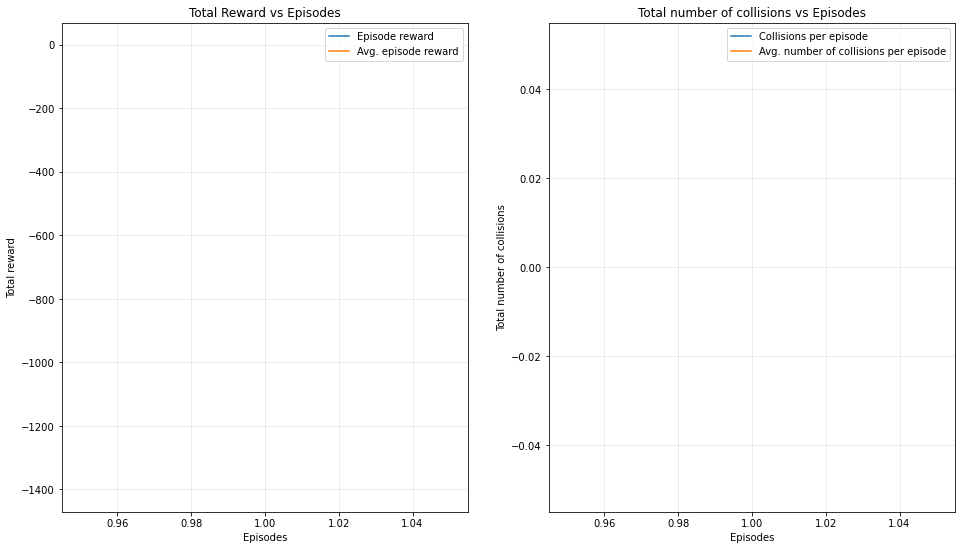

In [96]:

### Set up parameters ###
env = drone_env.drones(n_agents=3, n_obstacles=0, grid=[5, 5], end_formation="O", simplify_zstate = True)
print(env)
# env.show()

N_Episodes = 1

T = 4 # Simulate for T seconds (default dt = drone_env.dt = 0.01s) t_iter t=500
discount_factor = 0.99
alpha_critic = 10**-3
M = 20 # Epochs, i.e steps of the SDG for the critic NN
dim_z = env.local_state_space # Dimension of the localized z_state space
dim_a = env.local_action_space # Dimension of the local action space

### 

# Initialize variables
total_collisions_list = []
total_reward_list = []
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])

times = np.arange(0, T, step=drone_env.dt) + drone_env.dt


agents = SACAgents(n_agents=env.n_agents, dim_local_state = dim_z, dim_local_action=dim_a, discount=discount_factor, epochs=M, learning_rate_critic=alpha_critic)
print("### Running Scalable-Actor-Critic with params: ###")
print(f"Episodes = {N_Episodes}, Time iterations = {len(times)} (T = {T}s, dt = {drone_env.dt}s)")
print(f"N of agents = {env.n_agents}")
print(f"Discount = {discount_factor}, (lr for NN critical)  = {alpha_critic}, epochs M = {M}")

EPISODES = trange(N_Episodes, desc='Episode: ', leave=True)
for episode in EPISODES:

    # reward_history = np.zeros([len(times), env.n_agents])
    trajectory = [env.state.copy()]
    total_episode_reward = 0
    total_episode_collisions = 0
    # env.show()

    buffers = ExperienceBuffers(env.n_agents)
    # SIMULATION OVER T
    for t_iter, time in enumerate(times):
        # Simple gradient controller u_i = -grad_i, assuming Nj = V
        state = env.state
        z_states = env.z_states

        # calculate actions based on current state
        actions = drone_env.gradient_control(state, env)
        # actions = drone_env.proportional_control(state, env)

        # Update environment one time step with the actions
        new_state, new_z, rewards, n_collisions, finished = env.step(actions)
        # EXPERIECE: [z_state, action, reward, next_z, finished]
        buffers.append(z_states, actions, rewards,new_z, finished)

        total_episode_reward += np.mean(rewards)
        total_episode_collisions += n_collisions

        # reward_history[t_iter,:] = reward
        trajectory.append(new_state.copy())

    # END OF EPISODE
    # Append episode reward
    total_reward_list.append(total_episode_reward)
    total_collisions_list.append(total_episode_collisions)

    # Train of critic with the data of the episode
    agents.train_cirtic(buffers)
    Q_simulated, Q_approx = agents.benchmark_cirtic(buffers, only_one_NN=False)

    # print(f"Episode collisions = {total_episode_collisions}")
    # env.animate(trajectory,frame_time=0.1)

    # RESET ENVIRONMENT
    env.reset(renew_obstacles=False)

    # Set progress bar description with information
    average_reward = running_average(total_reward_list, 50)[-1]
    average_collisions = running_average(total_collisions_list, 50)[-1]
    EPISODES.set_description(
        f"Episode {episode} - Reward/Collisions/Steps: {total_episode_reward:.1f}/{total_episode_collisions}/{t_iter+1} - Average: {average_reward:.1f}/{average_collisions:.2f}/{t_iter+1}")

    # Plot current trajectory

    if episode >= N_Episodes-0:
        env.plot(trajectory)

        plt.figure()
        for i in range(env.n_agents):
            agent_color = drone_env.num_to_rgb(i,env.n_agents-1)
            plt.plot(times,Q_approx[i], label=f"i={i}, approx Q")
            plt.plot(times,Q_simulated[i], "--", label=f"i={i}, simulated Q")
        plt.legend()
        plt.show()

agents.save(filename="Q_test")

plot_rewards(total_reward_list,total_collisions_list, n_ep_running_average=5)